In [1]:
from dataset import BufferedGeoDataLoader
import xarray as xr
import numpy as np
from tqdm import tqdm
import time

In [2]:
buffer = BufferedGeoDataLoader(fold_id=0, num_wokers=8)

In [3]:
from project.pl_models.tcn_model import TemporalConvNetPL
from project.utils.torch_utils import count_parameters

In [4]:
batch = buffer.get_dummy_batch()

tcn = TemporalConvNetPL(
    num_inputs=4, num_geofactors=6, num_outputs=1, num_hidden=32, num_layers=3, dropout=0.2, static_dropout=0.2, kernel_size=3,
    tasks='fvc', lr=0.001, weight_decay=0.001)

In [6]:
tcn(batch.f_hourly, batch.f_static)

tensor([[[0.0585],
         [0.0759],
         [0.0547],
         ...,
         [0.0717],
         [0.0674],
         [0.0785]],

        [[0.0694],
         [0.0719],
         [0.0732],
         ...,
         [0.0706],
         [0.0740],
         [0.0842]],

        [[0.0784],
         [0.0576],
         [0.0786],
         ...,
         [0.0734],
         [0.0595],
         [0.0776]],

        ...,

        [[0.0905],
         [0.0797],
         [0.0785],
         ...,
         [0.0853],
         [0.0818],
         [0.0602]],

        [[0.0905],
         [0.0572],
         [0.0662],
         ...,
         [0.0580],
         [0.0794],
         [0.0743]],

        [[0.0728],
         [0.0748],
         [0.0632],
         ...,
         [0.0731],
         [0.0629],
         [0.0905]]], grad_fn=<PermuteBackward0>)

In [ ]:
train_loader = buffer.train_dataloader()

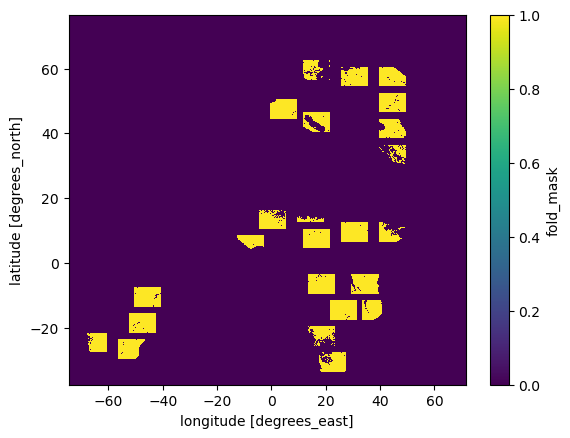

In [12]:
train_loader.dataset.mask.plot()

In [13]:
target = xr.full_like(train_loader.dataset.mask, np.nan, dtype='float32')

import traceback
try:
    for i, b in tqdm(enumerate(train_loader), maxinterval=0.1, total=len(train_loader), ncols=80):
        target.loc[{'lat': xr.DataArray(b.coords.lat), 'lon': xr.DataArray(b.coords.lon)}] = i
        time.sleep(0.5)
except:
    traceback.print_exc()

  0%|                                       | 1/2213 [01:25<52:42:52, 85.79s/it]
Traceback (most recent call last):
  File "/raid/scratch/tmp/ipykernel_46621/161158528.py", line 5, in <module>
    for i, b in tqdm(enumerate(train_loader), maxinterval=0.1, total=len(train_loader), ncols=80):
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/tqdm/std.py", line 1195, in __iter__
    for obj in iterable:
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 628, in __next__
    data = self._next_data()
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1316, in _next_data
    idx, data = self._get_data()
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1282, in _get_data
    success, data = self._try_get_data()
  File "/Net/Groups/BGI/peopl

RuntimeError: Given groups=1, weight of size [32, 4, 3], expected input[50, 24000, 4] to have 4 channels, but got 24000 channels instead

In [19]:
import matplotlib.pyplot as plt

In [44]:
b.f_hourly = b.f_hourly.view(b.f_hourly.shape[0], -1, b.f_hourly.shape[-1])

AttributeError: can't set attribute

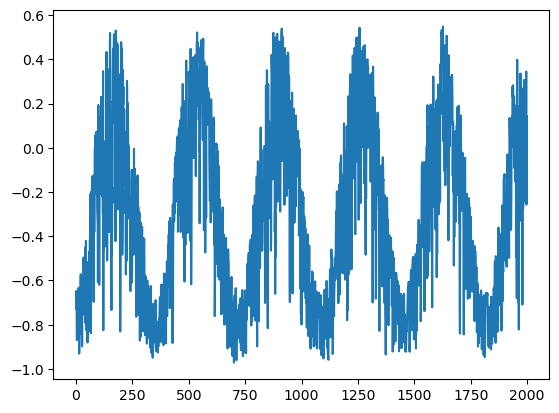

In [43]:
plt.plot(br[49, :2000, 1])

In [14]:
b.f_hourly.shape

torch.Size([50, 24, 7305, 4])

In [5]:
count_parameters(tcn)

+------------------------------------------+------------+
|                 Modules                  | Parameters |
+------------------------------------------+------------+
| feedforward_static.model.linear00.weight |    192     |
|  feedforward_static.model.linear00.bias  |     32     |
| feedforward_static.model.linear01.weight |    256     |
|  feedforward_static.model.linear01.bias  |     8      |
|           tcn.tcn.0.conv1.bias           |     32     |
|         tcn.tcn.0.conv1.weight_g         |     32     |
|         tcn.tcn.0.conv1.weight_v         |    384     |
|           tcn.tcn.0.conv2.bias           |     32     |
|         tcn.tcn.0.conv2.weight_g         |     32     |
|         tcn.tcn.0.conv2.weight_v         |    3072    |
|     tcn.tcn.0.res.downsample.weight      |    152     |
|      tcn.tcn.0.res.downsample.bias       |     38     |
|           tcn.tcn.1.conv1.bias           |     32     |
|         tcn.tcn.1.conv1.weight_g         |     32     |
|         tcn.

19347

In [3]:
tcn

TemporalConvNetPL(
  (feedforward_static): FeedForward(
    (model): Sequential(
      (linear00): Linear(in_features=6, out_features=32, bias=True)
      (dropout00): Dropout(p=0.2, inplace=False)
      (activation00): ReLU()
      (linear01): Linear(in_features=32, out_features=8, bias=True)
      (dropout01): Dropout(p=0.2, inplace=False)
      (activation01): Tanh()
    )
  )
  (tcn): TemporalConvNet(
    (to_sequence_last): Transform()
    (tcn): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (res): Residual(
          (downsample): Conv1d(4, 38, kernel_size=(1,), stride=(1,))
        )
        (relu): ReLU()
      )
      (1): Tem